In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from matplotlib import animation

plots = "plots/"
if not os.path.exists(plots):
    os.mkdir(plots)

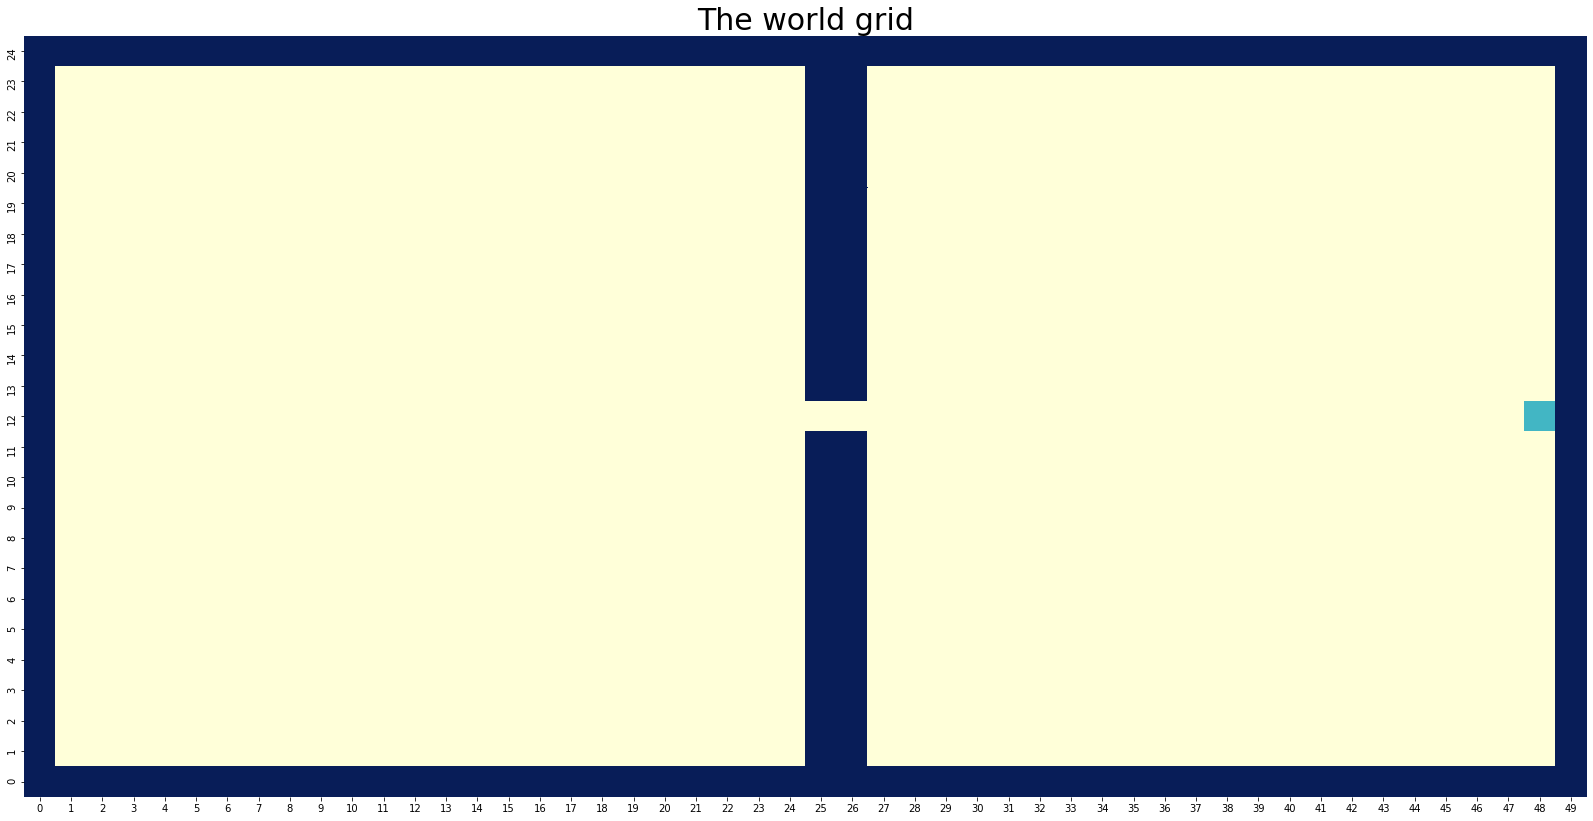

In [2]:
states = set()
for i in list(np.arange(1, 25)) + list(np.arange(27, 49)):
    for j in range(1, 24):
        states.add((i, j))
states.add((25, 12))
states.add((26, 12))

walls = set()
for i in range(50):
    walls.add((i, 0))
    walls.add((i, 24))
for j in range(25):
    walls.add((0, j))
    walls.add((49, j))
for j in list(np.arange(12)) + list(np.arange(13, 25)):
    walls.add((25, j))
    walls.add((26, j))

mat = np.zeros((25, 50))
for j in range(25):
    for i in range(50):
        if (i, j) in walls:
            mat[j, i] = 255
goal = (48, 12)
mat[goal[1], goal[0]] = 127
fig, ax = plt.subplots(1, 1, figsize =(28, 14))
ax.set_title("The world grid", fontsize=30)
ax.set_xlabel("X")
ax.set_ylabel("Y")
sns.heatmap(mat, cmap="YlGnBu", yticklabels=np.arange(24, -1, -1), cbar=False)
fig.savefig(plots+"theRobotGrid.png", bbox_inches="tight")
plt.show()

In [3]:
def value_iteration(theta, gamma, n_iter=100, save_at=set()):
    V = {}
    for s in states:
        V[s] = 0
    V[goal] = 0
    ans = []
    for n in range(n_iter):
        chg = 0
        new_V = {}
        for s in states:
            v = V[s]
            i, j = s
            values = []
            for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                val = 0
                for ti, tj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    p = 0.8 if (ni, nj) == (ti, tj) else 0.2/3
                    r = 0
                    if (ti, tj) == goal:
                        r = 100
                    elif s==goal and (ti, tj) in walls:
                        r = 100
                    elif (ti, tj) in walls:
                        r = -1
                    else:
                        r = 1 
                    val += p*(r + gamma*(V[(ti, tj)] if (ti, tj) in states else 0))
                values.append(val)
            new_V[s] = max(values)
            chg = max(chg, abs(v-new_V[s]))
        V = new_V
        if (n+1) in save_at:
            ans.append(V)
        if chg<theta:
            print(n)
            break
    ans.append(V)
    return ans    

In [4]:
def policy(V, gamma):
    pi = {}
    for s in states:
        i, j = s
        values = []
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            val = 0
            for ti, tj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                p = 0.8 if (ni, nj) == (ti, tj) else 0.2/3
                r = 0
                if (ti, tj) == goal:
                    r = 100
                elif s==goal and (ti, tj) in walls:
                    r = 100
                elif (ti, tj) in walls:
                    r = -1
                else:
                    r = 1 
                val += p*(r + gamma*(V[(ti, tj)] if (ti, tj) in states else 0))
            values.append((ni, nj, val))
        random.shuffle(values)
        values = sorted(values, key=lambda x: x[2], reverse=True)
        pi[s] = (values[0][0], values[0][1])
    return pi

## Part A

3


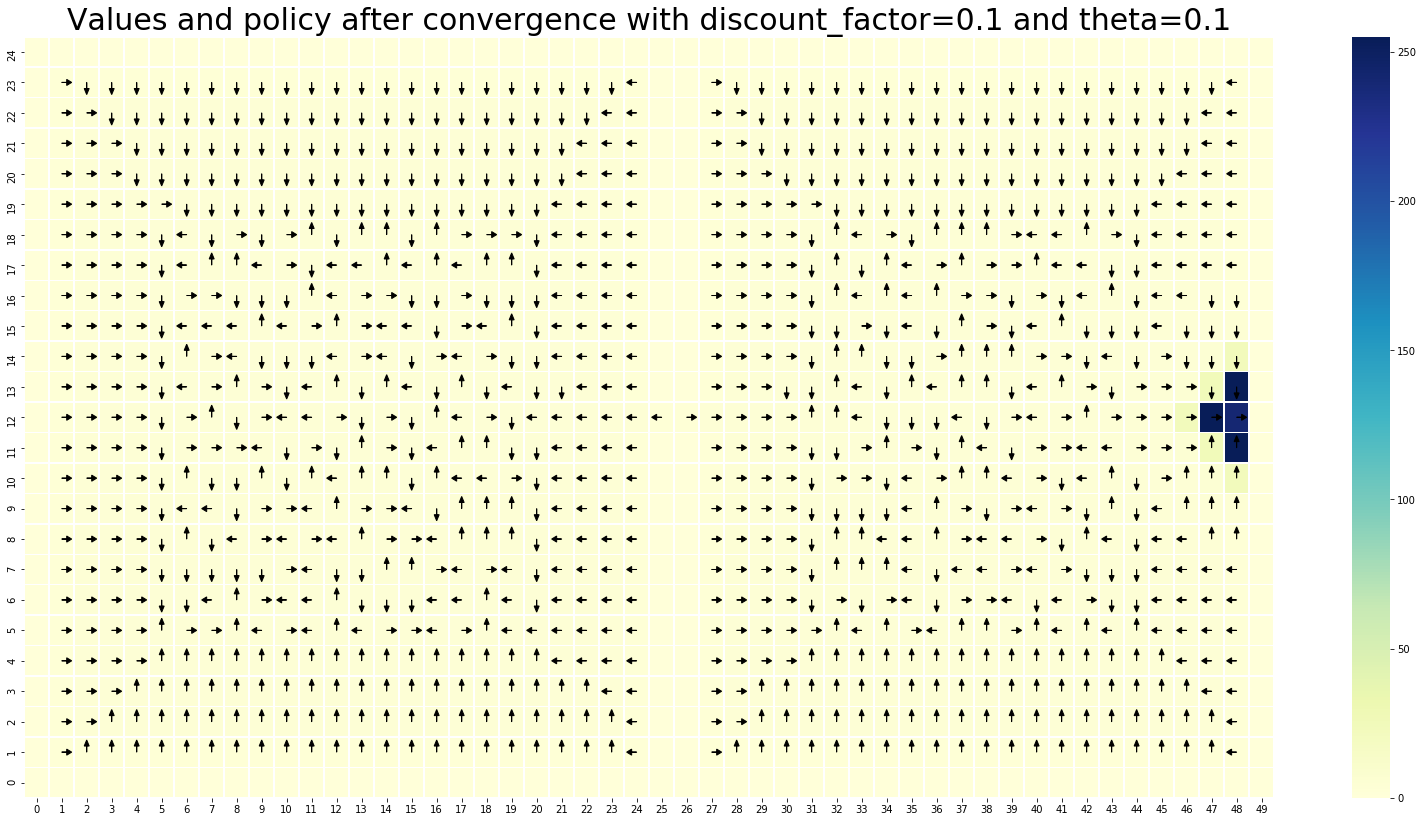

In [5]:
V = value_iteration(0.1, 0.1, 100, {100})[-1]
pi = policy(V, 0.1)

mat = np.zeros((25, 50))
for j in range(25):
    for i in range(50):
        if (i, j) in states:
            mat[j, i] = V[(i, j)]
            
fig, ax = plt.subplots(1, 1, figsize =(28, 14))
mat = (mat - mat.min())*255/(mat.max()-mat.min())

for s in states:
    x, y = s
    nx, ny = pi[s]
    plt.arrow(x+0.5, y+0.5, (nx-x)*0.2, (ny-y)*0.2, fc="k", ec="k", head_width=0.2, head_length=0.2)

ax.set_title("Values and policy after convergence with discount_factor=0.1 and theta=0.1", fontsize=30)
ax.set_xlabel("X")
ax.set_ylabel("Y")
sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1))
fig.savefig(plots+"partA.png", bbox_inches="tight")
plt.show()

## Part B

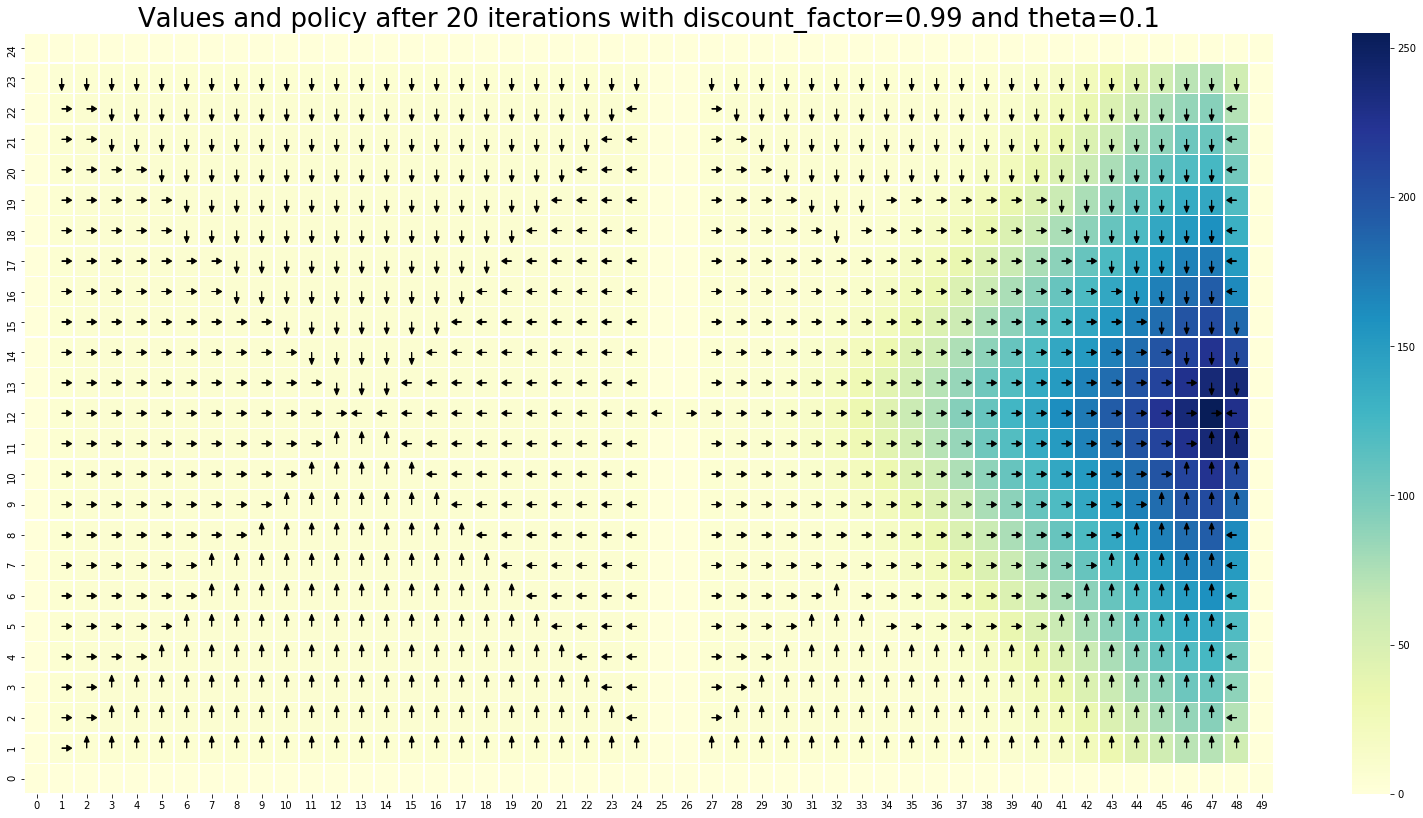

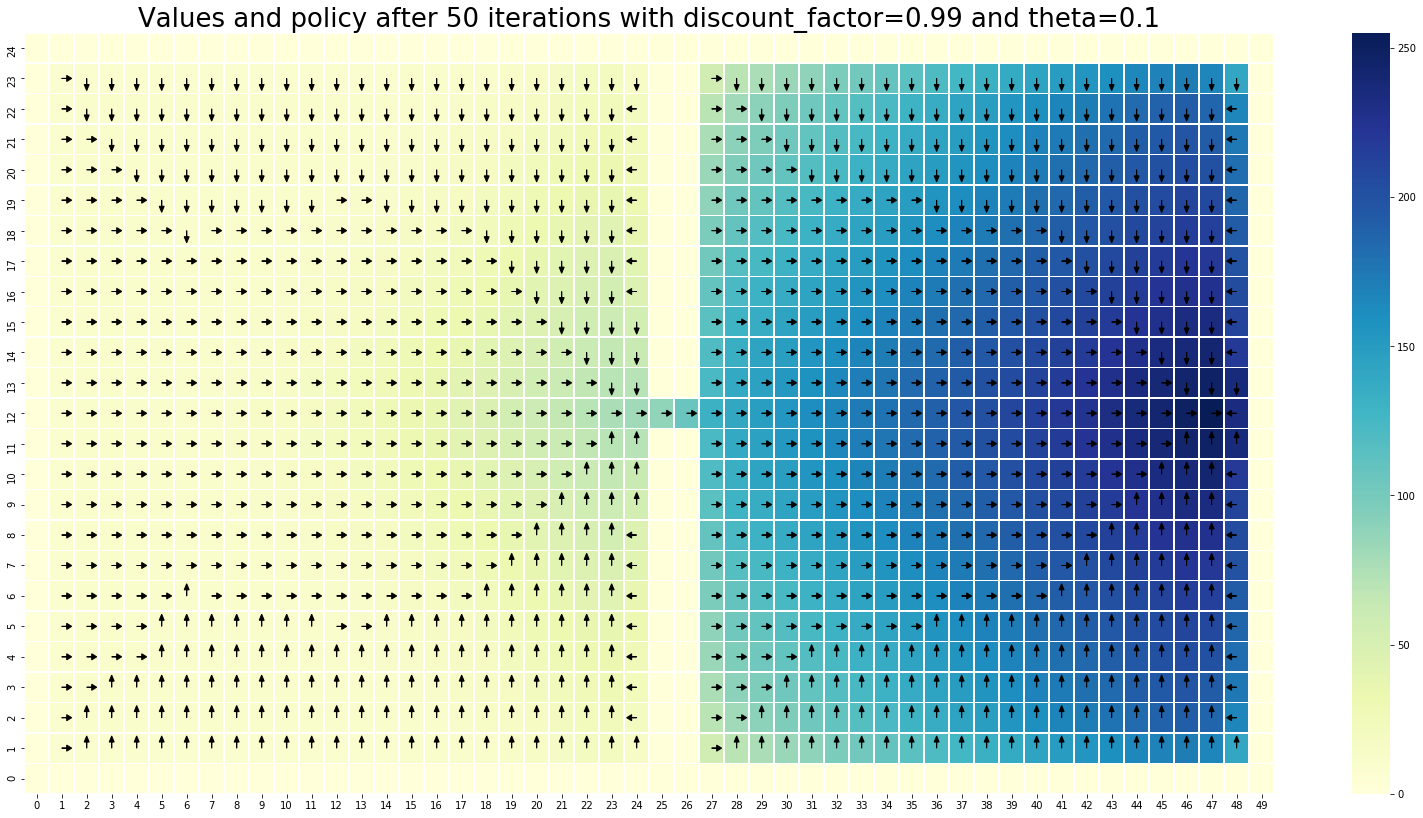

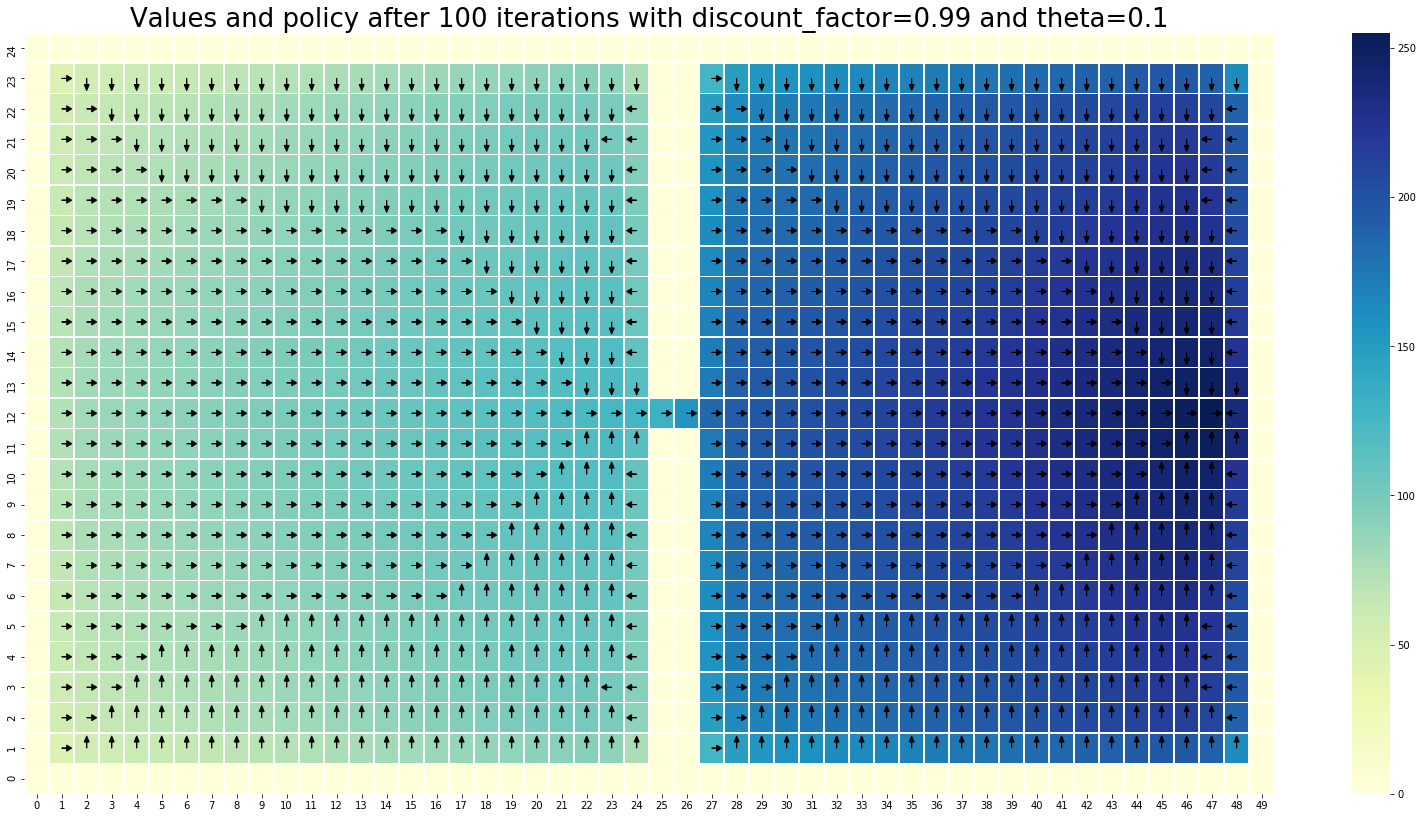

In [6]:
save_at = [20, 50, 100]
gamma = 0.99
Values = value_iteration(0.1, gamma, 100, {20, 50})
for n, V in enumerate(Values):
    pi = policy(V, gamma)

    mat = np.zeros((25, 50))
    for j in range(25):
        for i in range(50):
            if (i, j) in states:
                mat[j, i] = V[(i, j)]

    fig, ax = plt.subplots(1, 1, figsize =(28, 14))
    mat = (mat - mat.min())*255/(mat.max()-mat.min())

    for s in states:
        x, y = s
        nx, ny = pi[s]
        plt.arrow(x+0.5, y+0.5, (nx-x)*0.2, (ny-y)*0.2, fc="k", ec="k", head_width=0.2, head_length=0.2)

    ax.set_title("Values and policy after "+str(save_at[n])+" iterations with discount_factor=0.99 and theta=0.1", fontsize=26)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1))
    fig.savefig(plots+"partB_"+str(save_at[n])+".png", bbox_inches="tight")
    plt.show()

## Part C

In [7]:
def execution(pi, ep_len = 400, cur_state=(1, 23)):
    visit = [cur_state]
    for _ in range(ep_len):
        i, j = cur_state
        nxt = {(i-1, j), (i+1, j), (i, j-1), (i, j+1)}
        nxt.remove(pi[cur_state])
        nxt = [pi[cur_state]] + list(nxt)
        prob = [0.8, 0.2/3, 0.2/3, 0.2/3]
        nxt = random.choices(nxt, weights=prob, k=1)[0]
        if nxt in states:
            cur_state = nxt
        visit.append(cur_state)
    return visit

In [8]:
gamma = 0.99
V = value_iteration(0.1, gamma, 100)[-1]
pi = policy(V, gamma)

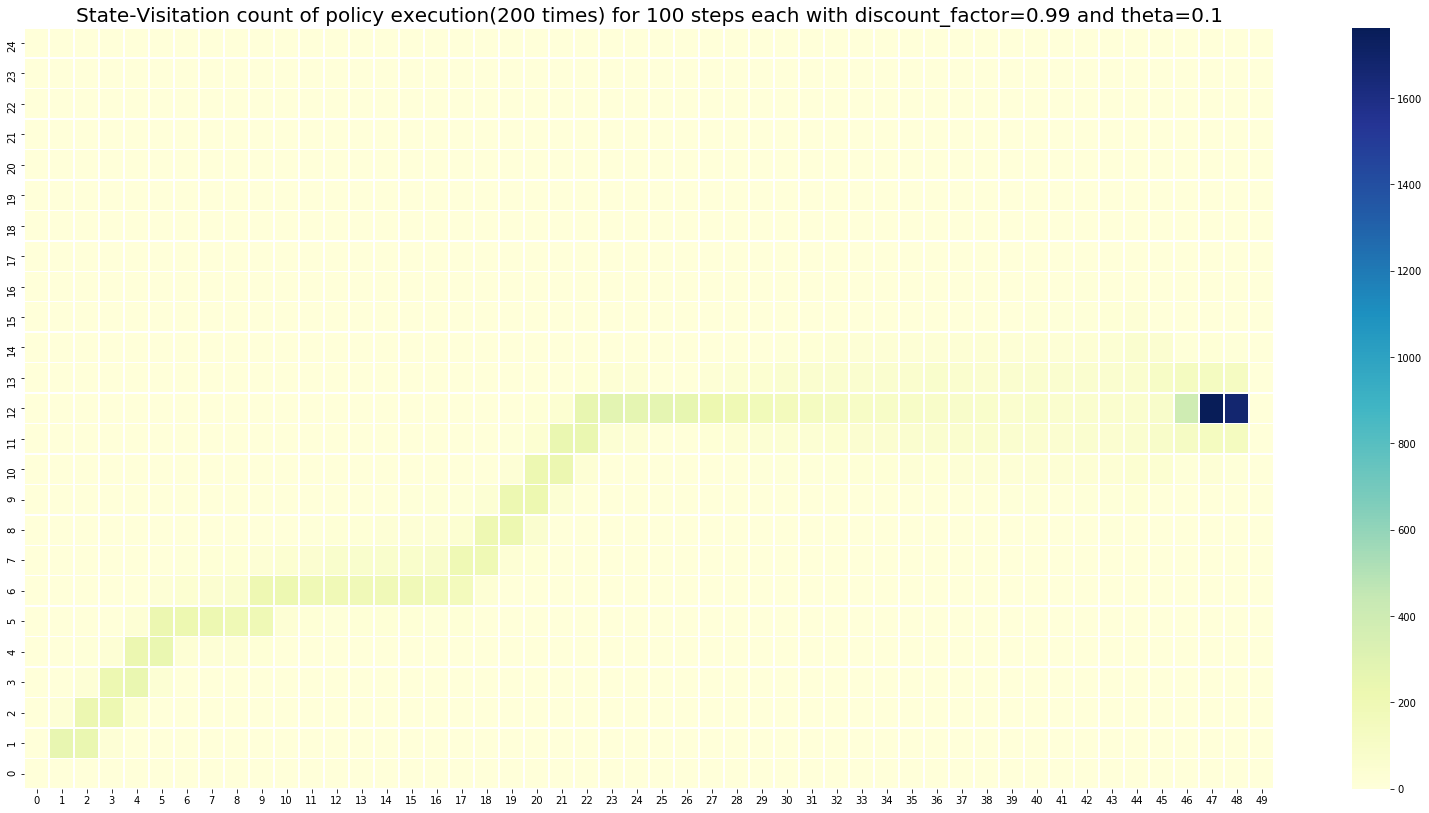

In [9]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))
n_sim, ep_len = 200, 100
ax.set_title("State-Visitation count of policy execution("+str(n_sim)+" times) for "+str(ep_len)+" steps each with discount_factor=0.99 and theta=0.1", 
             fontsize=20)

mat = np.zeros((25, 50))

for _ in range(n_sim):
    visits = execution(pi, ep_len)
    for v in visits:
        mat[v[1], v[0]] += 1

hm = sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1))
fig.savefig(plots+"partC_state_visit_"+str(ep_len)+".png", bbox_inches="tight")

In [10]:
ep_len = 400
visit = execution(pi, ep_len)

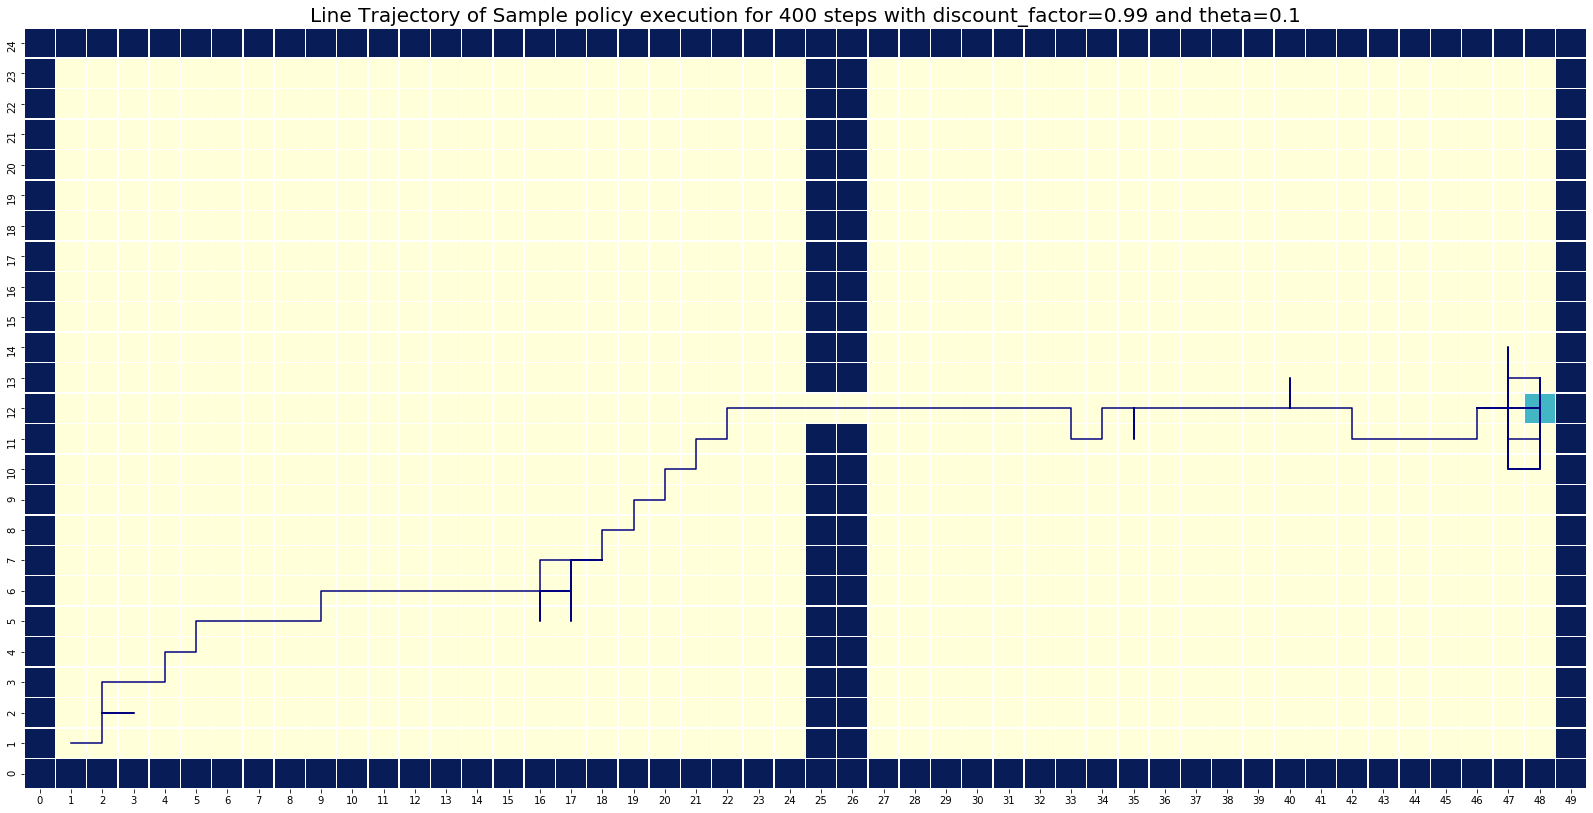

In [11]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))

ax.set_title("Line Trajectory of Sample policy execution for 400 steps with discount_factor=0.99 and theta=0.1", fontsize=20)
ax.set_xlabel("X")
ax.set_ylabel("Y")

mat = np.zeros((25, 50))
for j in range(25):
    for i in range(50):
        if (i, j) in walls:
            mat[j, i] = 255
mat[goal[1], goal[0]] = 127

hm = sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1), cbar=False)
x_ticks, y_ticks = [visit[n][0]+0.5 for n in range(ep_len)], [visit[n][1]+0.5 for n in range(ep_len)]
ax.plot(x_ticks, y_ticks, color="navy")
fig.savefig(plots+"partC_lineTraject.png", bbox_inches="tight")

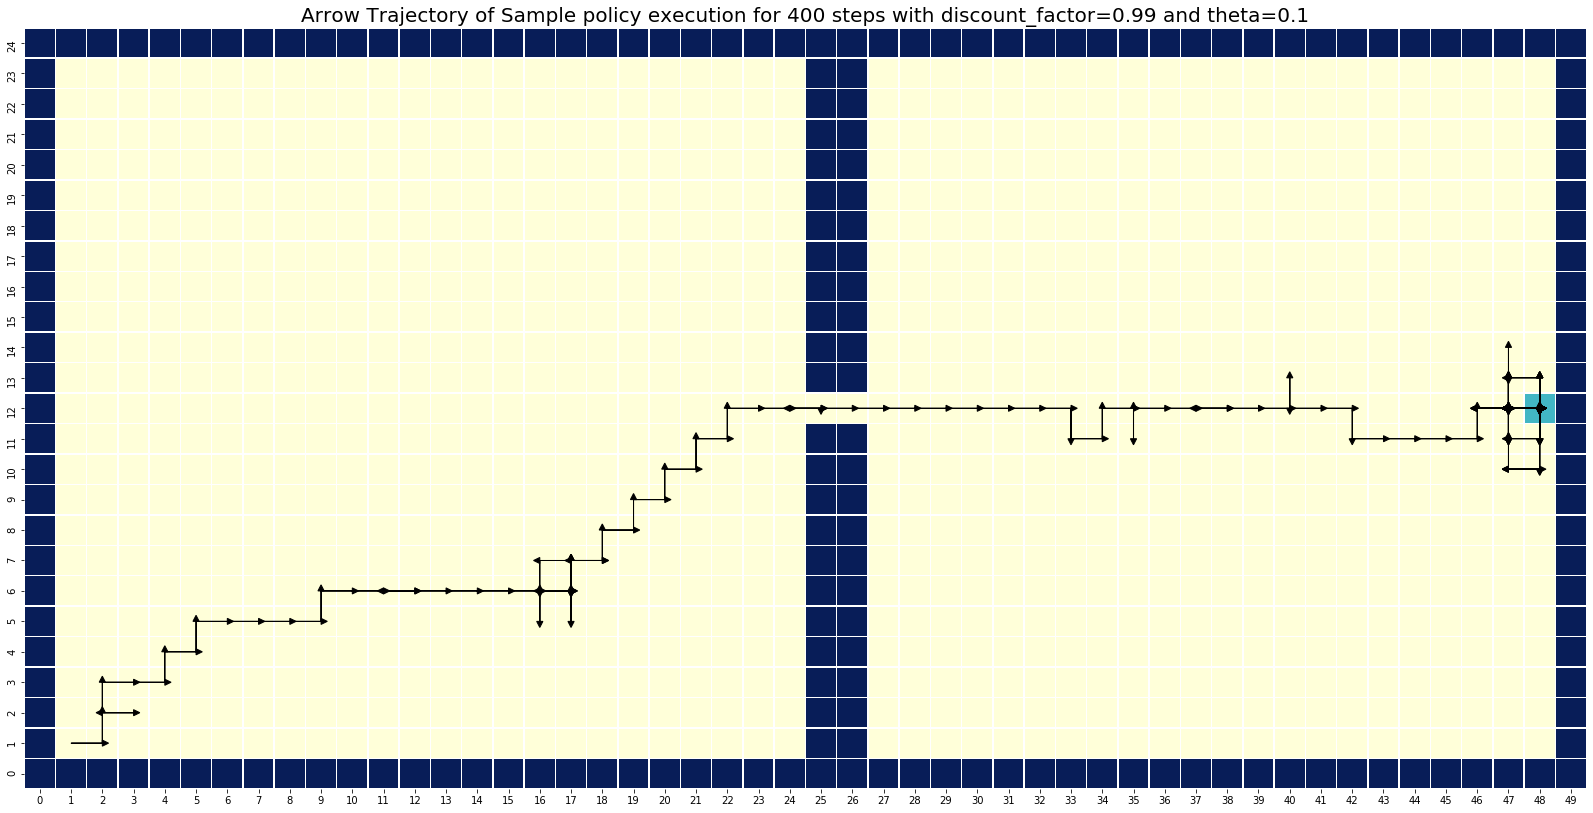

In [12]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))

ax.set_title("Arrow Trajectory of Sample policy execution for 400 steps with discount_factor=0.99 and theta=0.1", fontsize=20)
ax.set_xlabel("X")
ax.set_ylabel("Y")

mat = np.zeros((25, 50))
for j in range(25):
    for i in range(50):
        if (i, j) in walls:
            mat[j, i] = 255
mat[goal[1], goal[0]] = 127
hm = sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1), cbar=False)
for n in range(1, ep_len):
    x, y = visit[n-1]
    nx, ny = visit[n]
    plt.arrow(x+0.5, y+0.5, (nx-x), (ny-y), fc="k", ec="k", head_width=0.2, head_length=0.2)
# x_ticks, y_ticks = [visit[n][0]+0.5 for n in range(ep_len)], [visit[n][1]+0.5 for n in range(ep_len)]
# ax.plot(x_ticks, y_ticks, color="navy")
fig.savefig(plots+"partC_arrowTraject.png", bbox_inches="tight")

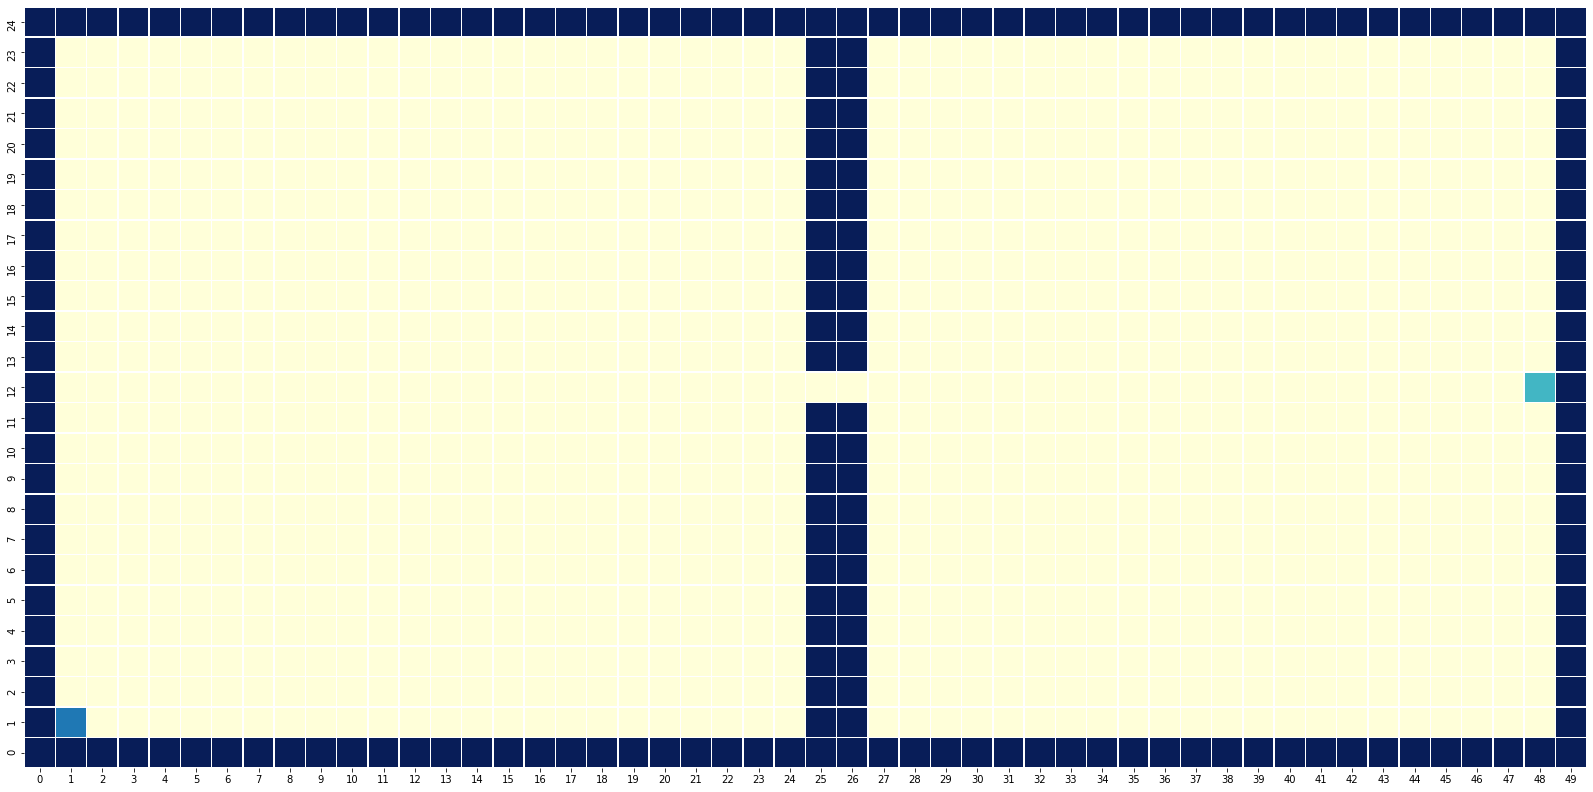

In [14]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))

# ax.set_title("Video of 100 steps of sample policy execution with discount_factor=0.99 and theta=0.1", fontsize=20)
ax.set_xlabel("X")
ax.set_ylabel("Y")

mat = np.zeros((25, 50))
for j in range(25):
    for i in range(50):
        if (i, j) in walls:
            mat[j, i] = 255
mat[goal[1], goal[0]] = 127

#Update function for animation
def update(n, states):
    i, j = states[n]
    mat[j, i] = 175
    hm = sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1), cbar=False)
    mat[j,i] = 127 if (i, j) == goal else 0
    return hm

#Animating the movement and saving it in a file
ani = animation.FuncAnimation(fig, update, 100, fargs=([visit]))
writer = animation.writers['ffmpeg'](fps=5)
dpi = 50
ani.save('videoPartC.mp4',writer=writer,dpi=dpi)

## Part D

In [5]:
def policy_after_each_iteration(gamma, theta=0.1, n_iter=100):
    V = {}
    for s in states:
        V[s] = 0
    V[goal] = 0

    max_norm = []
    pis = []
    for n in range(n_iter):
        chg = 0
        new_V = {}
        for s in states:
            v = V[s]
            i, j = s
            values = []
            for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                val = 0
                for ti, tj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    p = 0.8 if (ni, nj) == (ti, tj) else 0.2/3
                    r = 0
                    if (ti, tj) == goal:
                        r = 100
                    elif s==goal and (ti, tj) in walls:
                        r = 100
                    elif (ti, tj) in walls:
                        r = -1
                    else:
                        r = 1 
                    val += p*(r + gamma*(V[(ti, tj)] if (ti, tj) in states else 0))
                values.append(val)
            new_V[s] = max(values)
            chg = max(chg, abs(v-new_V[s]))
        V = new_V
        max_norm.append(chg)
        pis.append((V, policy(V, gamma)))
        if chg<theta:
            print(n)
            break
    return max_norm, pis

In [6]:
def diff_in_policy(p1, p2):
    t = 0
    for s in states:
        if p1[s]!=p2[s]:
            t += 1
    return t

In [7]:
gamma1, gamma2 = 0.01, 0.99
m1, p1 = policy_after_each_iteration(gamma1, 0)
m2, p2 = policy_after_each_iteration(gamma2, 0)

d1 = []
for i in range(1, len(p1)):
    d1.append(diff_in_policy(p1[i-1][1], p1[i][1]))

d2 = []
for i in range(1, len(p2)):
    d2.append(diff_in_policy(p2[i-1][1], p2[i][1]))

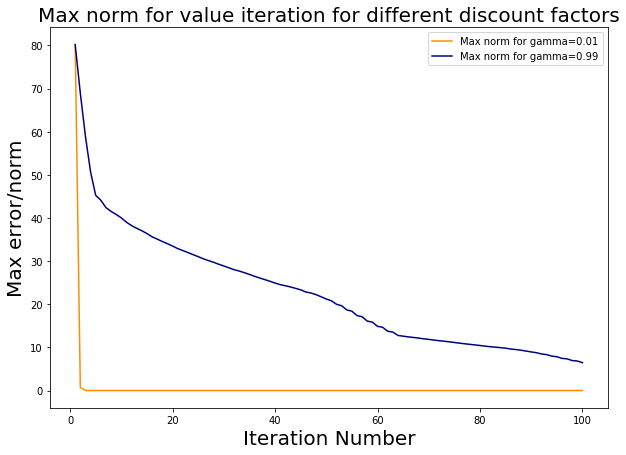

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize =(10, 7))
ax1.set_title("Max norm for value iteration for different discount factors", fontsize=20)
ax1.set_xlabel("Iteration Number", fontsize=20)
ax1.set_ylabel("Max error/norm", fontsize=20)
ax1.plot(np.arange(1, len(m1)+1), m1, label="Max norm for gamma=%0.2f"%(gamma1), color="darkorange")
ax1.plot(np.arange(1, len(m2)+1), m2, label="Max norm for gamma=%0.2f"%(gamma2), color="navy")
ax1.legend(loc='upper right')
fig1.savefig(plots+"partD_max_norm.png", bbox_inches="tight")

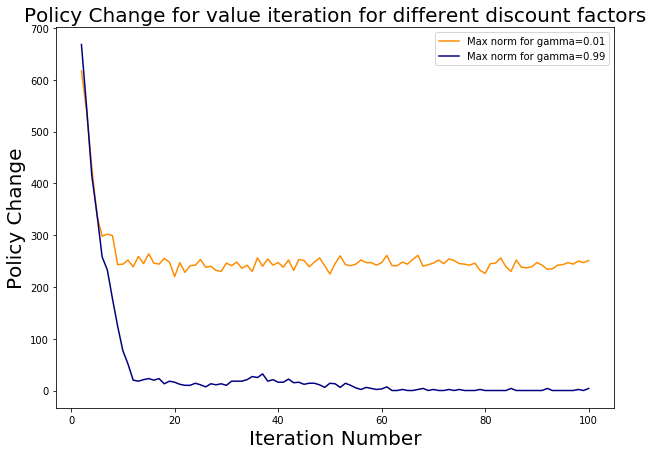

In [11]:
fig2, ax2 = plt.subplots(1, 1, figsize =(10, 7))
ax2.set_title("Policy Change for value iteration for different discount factors", fontsize=20)
ax2.set_xlabel("Iteration Number", fontsize=20)
ax2.set_ylabel("Policy Change", fontsize=20)
ax2.plot(np.arange(2, len(d1)+2), d1, label="Max norm for gamma=%0.2f"%(gamma1), color="darkorange")
ax2.plot(np.arange(2, len(d2)+2), d2, label="Max norm for gamma=%0.2f"%(gamma2), color="navy")
ax2.legend(loc='upper right')
fig2.savefig(plots+"partD_policy_loss.png", bbox_inches="tight")

0.01 0
0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.01 11
0.01 12
0.01 13
0.01 14
0.01 15
0.01 16
0.01 17
0.01 18
0.01 19
0.01 20
0.01 21
0.01 22
0.01 23
0.01 24
0.01 25
0.01 26
0.01 27
0.01 28
0.01 29
0.01 30
0.01 31
0.01 32
0.01 33
0.01 34
0.01 35
0.01 36
0.01 37
0.01 38
0.01 39
0.01 40
0.01 41
0.01 42
0.01 43
0.01 44
0.01 45
0.01 46
0.01 47
0.01 48
0.01 49
0.01 50
0.01 51
0.01 52
0.01 53
0.01 54
0.01 55
0.01 56
0.01 57
0.01 58
0.01 59
0.01 60
0.01 61
0.01 62
0.01 63
0.01 64
0.01 65
0.01 66
0.01 67
0.01 68
0.01 69
0.01 70
0.01 71
0.01 72
0.01 73
0.01 74
0.01 75
0.01 76
0.01 77
0.01 78
0.01 79
0.01 80
0.01 81
0.01 82
0.01 83
0.01 84
0.01 85
0.01 86
0.01 87
0.01 88
0.01 89
0.01 90
0.01 91
0.01 92
0.01 93
0.01 94
0.01 95
0.01 96
0.01 97
0.01 98
0.01 99
0.01 0


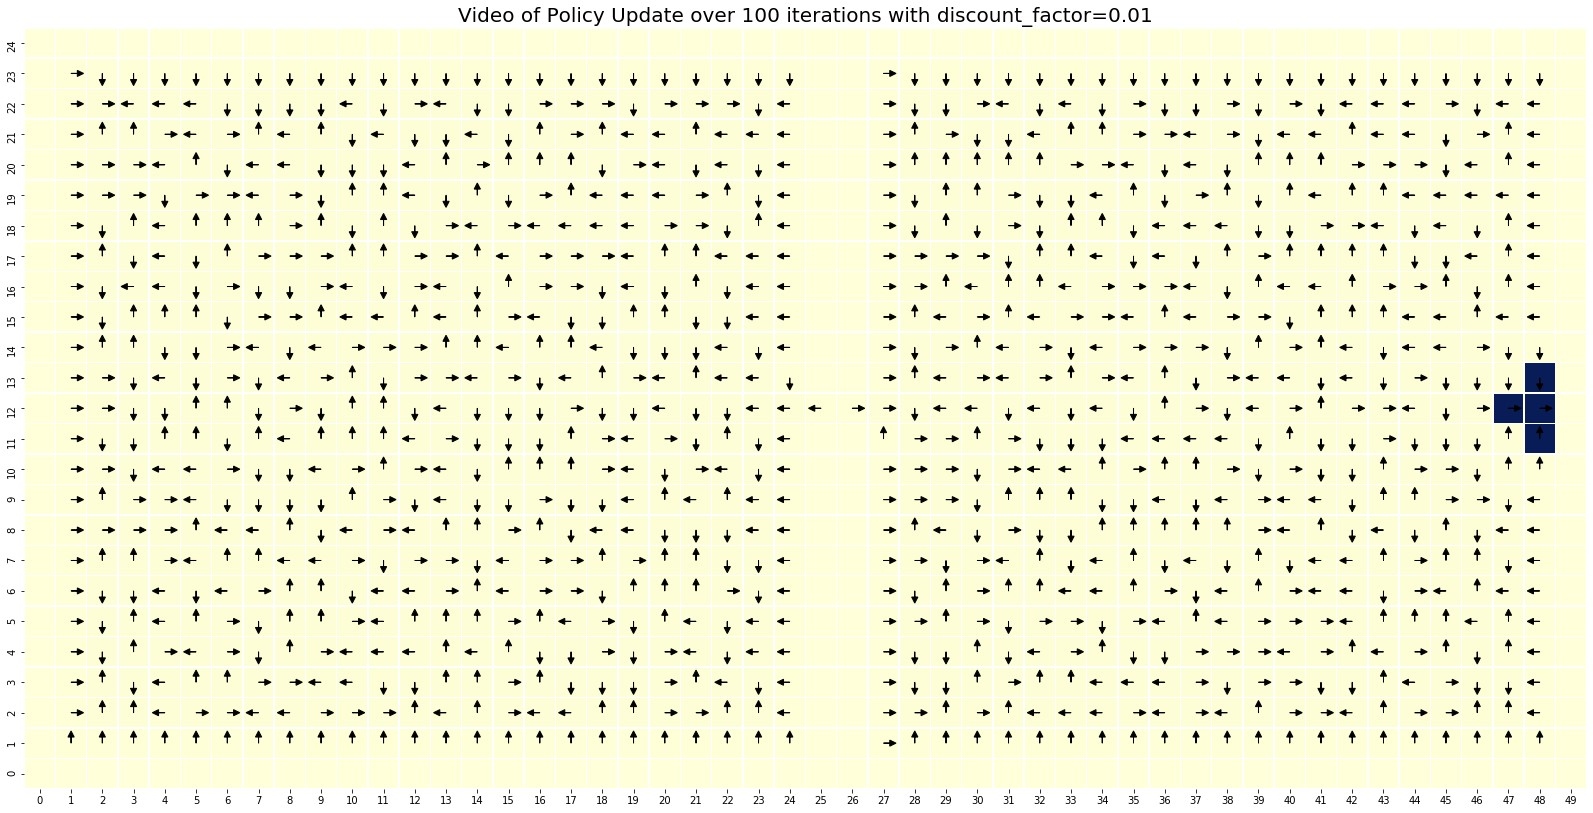

In [15]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))

#Update function for animation
def update(n, pis):
    print(0.01, n)
    V, pi = pis[n]
    ax.clear()
    ax.set_title("Video of Policy Update over 100 iterations with discount_factor=0.01", fontsize=20)
    mat = np.zeros((25, 50))
    for j in range(25):
        for i in range(50):
            if (i, j) in states:
                mat[j, i] = V[(i, j)]

    mat = (mat - mat.min())*255/(mat.max()-mat.min())
    
    sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1), ax = ax, cbar=False)
    
    for s in states:
        x, y = s
        nx, ny = pi[s]
        ax.arrow(x+0.5, y+0.5, (nx-x)*0.2, (ny-y)*0.2, fc="k", ec="k", head_width=0.2, head_length=0.2)
    
    return ax

#Animating the movement and saving it in a file
ani = animation.FuncAnimation(fig, update, 100, fargs=([p1]))
writer = animation.writers['ffmpeg'](fps=5)
dpi = 30
ani.save('videoPartD_01.mp4',writer=writer,dpi=dpi)

0.99 0
0.99 0
0.99 1
0.99 2
0.99 3
0.99 4
0.99 5
0.99 6
0.99 7
0.99 8
0.99 9
0.99 10
0.99 11
0.99 12
0.99 13
0.99 14
0.99 15
0.99 16
0.99 17
0.99 18
0.99 19
0.99 20
0.99 21
0.99 22
0.99 23
0.99 24
0.99 25
0.99 26
0.99 27
0.99 28
0.99 29
0.99 30
0.99 31
0.99 32
0.99 33
0.99 34
0.99 35
0.99 36
0.99 37
0.99 38
0.99 39
0.99 40
0.99 41
0.99 42
0.99 43
0.99 44
0.99 45
0.99 46
0.99 47
0.99 48
0.99 49
0.99 50
0.99 51
0.99 52
0.99 53
0.99 54
0.99 55
0.99 56
0.99 57
0.99 58
0.99 59
0.99 60
0.99 61
0.99 62
0.99 63
0.99 64
0.99 65
0.99 66
0.99 67
0.99 68
0.99 69
0.99 70
0.99 71
0.99 72
0.99 73
0.99 74
0.99 75
0.99 76
0.99 77
0.99 78
0.99 79
0.99 80
0.99 81
0.99 82
0.99 83
0.99 84
0.99 85
0.99 86
0.99 87
0.99 88
0.99 89
0.99 90
0.99 91
0.99 92
0.99 93
0.99 94
0.99 95
0.99 96
0.99 97
0.99 98
0.99 99
0.99 0


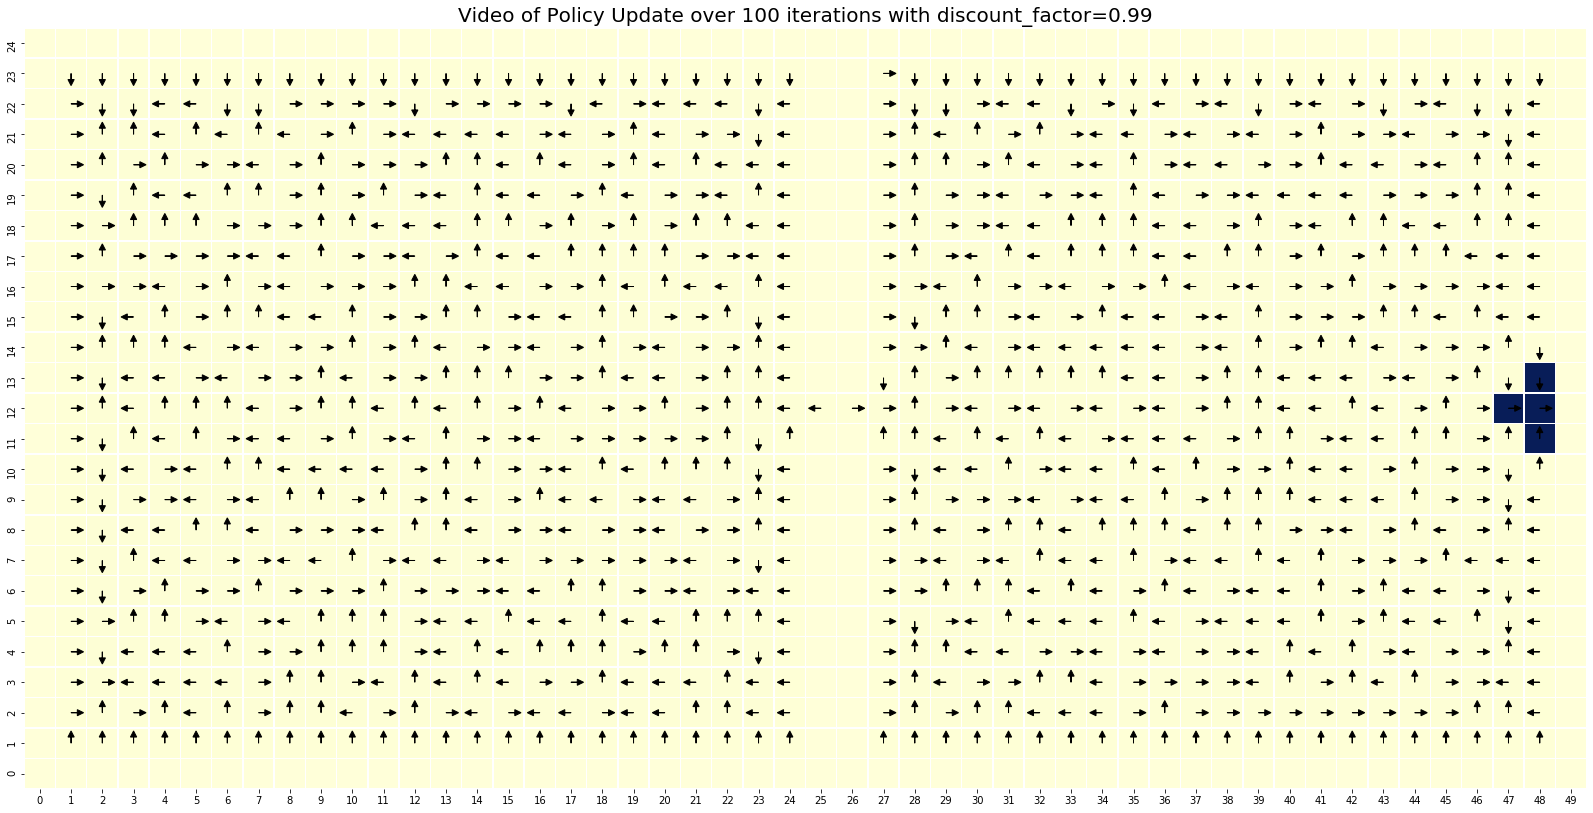

In [13]:
fig, ax = plt.subplots(1, 1, figsize =(28, 14))

#Update function for animation
def update(n, pis):
    print(0.99, n)
    V, pi = pis[n]
    ax.clear()
    ax.set_title("Video of Policy Update over 100 iterations with discount_factor=0.99", fontsize=20)
    mat = np.zeros((25, 50))
    for j in range(25):
        for i in range(50):
            if (i, j) in states:
                mat[j, i] = V[(i, j)]

    mat = (mat - mat.min())*255/(mat.max()-mat.min())
    
    sns.heatmap(mat, cmap="YlGnBu", linewidth=0.5, yticklabels=np.arange(24, -1, -1), ax = ax, cbar=False)
    
    for s in states:
        x, y = s
        nx, ny = pi[s]
        ax.arrow(x+0.5, y+0.5, (nx-x)*0.2, (ny-y)*0.2, fc="k", ec="k", head_width=0.2, head_length=0.2)
    
    return ax

#Animating the movement and saving it in a file
ani = animation.FuncAnimation(fig, update, 100, fargs=([p2]))
writer = animation.writers['ffmpeg'](fps=5)
dpi = 30
ani.save('videoPartD_99.mp4',writer=writer,dpi=dpi)